# SegCapsR3 on Image Segmentation for Person
## Input Color image files map to 24 bits data space.
## loss function = dice
## 10 epochs, 1,000 iterations per epoch.

A quick intro to using the pre-trained model to detect and segment object of person.

This notebook tests the model loading function from image file of a saved model.

In [3]:
import os
from os import path
from os.path import join, basename
import sys
import random
import math

import warnings
warnings.filterwarnings('ignore')

# import SimpleITK as sitk
import numpy as np
# import skimage.io
# import matplotlib
import matplotlib.pyplot as plt
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('../')

from keras.utils import print_summary
from keras import layers, models

import segcapsnet.capsnet as modellib
import models.unet as unet

from utils.model_helper import create_model
from utils.load_2D_data import generate_test_batches, generate_test_image
from utils.custom_data_aug import augmentImages, process_image, image_resize2square
from test import *
from PIL import Image
import scipy.ndimage.morphology
from skimage import measure, filters
from datetime import datetime


%matplotlib inline 

RESOLUTION = 512

# Root directory of the project
ROOT_DIR = path.dirname("../")
DATA_DIR = path.join(ROOT_DIR, "data")

# Directory to save logs and trained model
# MODEL_DIR = path.join(DATA_DIR, "saved_models/segcapsr3/m1.hdf5") # LUNA16

# Local path to trained weights file
# loss function = Dice is better than BCE (Binary Cross Entropy)
COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.01_recon-2.0_model_20180702-055808.hdf5") # MSCOCO17

# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.001_recon-5.0_model_20180703-152449.hdf5") # poor
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.01_recon-2.0_model_20180703-180852.hdf5") # good
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.01_recon-2.0_model_20180703-210306.hdf5") # ?
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.01_recon-20.0_model_20180703-221150.hdf5") # ?
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.1_recon-20.0_model_20180703-225112.hdf5") # better
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.0001_recon-20.0_model_20180703-234853.hdf5") # best
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-1_loss-dice_slic-1_sub--1_strid-1_lr-0.001_recon-0.5_model_20180704-030457.hdf5") # ok
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/split-0_batch-1_shuff-1_aug-0_loss-dice_slic-1_sub--1_strid-1_lr-0.0001_recon-20.0_model_20180705-092846.hdf5") # best


# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/capsbasic/cb1.hdf5") # MSCOCO17
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/mar10-255.hdf5") # MSCOCO17
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/bce.hdf5") # MSCOCO17
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/unet/unet1.hdf5") # MSCOCO17


# Directory of images to run detection on
IMAGE_DIR = path.join(DATA_DIR, "imgs")

Using TensorFlow backend.


## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
net_input_shape = (RESOLUTION, RESOLUTION, 1)
num_class = 2
train_model, eval_model, manipulate_model = modellib.CapsNetR3(net_input_shape, num_class)
# train_model, eval_model, manipulate_model = modellib.CapsNetBasic(net_input_shape, num_class)
# eval_model = unet.UNet(net_input_shape)

# Load weights trained on MS-COCO
eval_model.load_weights(COCO_MODEL_PATH)
print_summary(model=eval_model)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 512, 512, 1,  0           conv1[0][0]                      
__________________________________________________________________________________________________
primarycaps (ConvCapsuleLayer)  (None, 256, 256, 2,  12832       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_cap_2

In [5]:

def threshold_mask(raw_output, threshold):
    if threshold == 0:
        try:
            threshold = filters.threshold_otsu(raw_output)
        except:
            threshold = 0.5

    print('\tThreshold: {}'.format(threshold))

    raw_output[raw_output > threshold] = 1
    raw_output[raw_output < 1] = 0

    all_labels = measure.label(raw_output)
    props = measure.regionprops(all_labels)
    props.sort(key=lambda x: x.area, reverse=True)
    thresholded_mask = np.zeros(raw_output.shape)

    if len(props) >= 2:
        if props[0].area / props[1].area > 5:  # if the largest is way larger than the second largest
            thresholded_mask[all_labels == props[0].label] = 1  # only turn on the largest component
        else:
            thresholded_mask[all_labels == props[0].label] = 1  # turn on two largest components
            thresholded_mask[all_labels == props[1].label] = 1
    elif len(props):
        thresholded_mask[all_labels == props[0].label] = 1

    thresholded_mask = scipy.ndimage.morphology.binary_fill_holes(thresholded_mask).astype(np.uint8)

    return thresholded_mask


## Predict the Segmentation of Person



In [6]:
img = ['train1.png']
# img = ['train-i-0.png']
# img = ['experiment/train2.png']
output_array = None


# sitk_img = sitk.ReadImage(join(IMAGE_DIR, img[0]))
# img_data = sitk.GetArrayFromImage(sitk_img)
img_data = np.array(Image.open(join(IMAGE_DIR, img[0])))
    
print(str(datetime.now()))
output_array = eval_model.predict_generator(generate_test_image(img_data,
                                                                  net_input_shape,
                                                                  batchSize=1,
                                                                  numSlices=1,
                                                                  subSampAmt=0,
                                                                  stride=1),
                                            steps=1, max_queue_size=1, workers=1,
                                            use_multiprocessing=False, verbose=1)

print(str(datetime.now()))

2018-07-07 09:39:54.357989
1/1 [==============================] - 46s 46s/step
2018-07-07 09:40:40.381549


In [7]:
# output_array contain 2 masks in a list, show the first element.
# print('len(output_array)=%d'%(len(output_array)))
# print('test.test: output_array=%s'%(output_array[0]))


In [8]:
# output = (1, 512, 512)
output = output_array[0][:,:,:,0] # A list with two images, get first one image and reshape it to 3 dimensions.
recon = output_array[1][:,:,:,0]

# For unet
# output = output_array[:,:,:,0]
# image store in tuple structure.
print('test.test: output=%s'%(output))
np.ndim(output)
np_output = np.array(output)





test.test: output=[[[0.45679113 0.47127154 0.47420034 ... 0.47056085 0.476707   0.44596344]
  [0.45354244 0.4923004  0.50066    ... 0.52313673 0.5206716  0.4923097 ]
  [0.46662143 0.49274352 0.50101686 ... 0.49266818 0.51320624 0.4601742 ]
  ...
  [0.47809583 0.5183113  0.5074172  ... 0.49978504 0.5070888  0.5099464 ]
  [0.492699   0.50687975 0.5185486  ... 0.5102853  0.5101571  0.49890918]
  [0.5134815  0.5011084  0.5136996  ... 0.52847296 0.503086   0.4882646 ]]]


In [9]:
# output_img = sitk.GetImageFromArray(output[0,:,:], isVector=True)

print('Segmenting Output')
threshold_level = 0
output_bin = threshold_mask(output, threshold_level)
# output2d = output[0,:,:]
# output2d = recon[0,:,:]
# print(output2d)

Segmenting Output
	Threshold: 0.6128642031690106


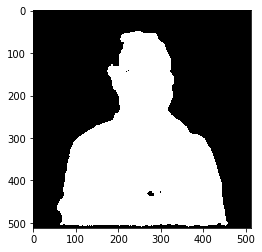

In [10]:
# plt.imsave('raw_output' + img[0][-4:], output[0,:,:])
plt.imshow(output_bin[0,:,:], cmap='gray')
# plt.imsave('segcapsr3-lr-0.001-iter1000-ep7' + img[0][-4:], output_bin[0,:,:])
